In [13]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

np.random.seed(1)

# p : X -> [0,1]
# Sigmoid function is monotonic
def p(x) -> float:
    return 1 / (1 + np.exp(-x))

def expected(x, plus, minus):
    return p(x) * plus + (1-p(x)) * minus

#Vectorized optimal step
def opt_step(X, u_plus, u_minus, c_plus, c_minus):
    X = np.asarray(X)

    #Apply change to X if expected utility is positive 
    exp_util = expected(X, u_plus, u_minus) 
    delta_x = expected(X, c_plus, c_minus)

    max_util = np.where(exp_util > 0, X + delta_x, X) 

    #Smallest threshold where utility is positive
    thresholds = X[exp_util > 0]
    opt_thresh = np.min(thresholds) if thresholds.size > 0 else None

    return (max_util, opt_thresh)


def change(A, B, a, b, c_plus, c_minus, u_plus, u_minus, prob=0.4):
    # a and b are thresholds

    A = np.asarray(A)
    B = np.asarray(B)

    delta_a = expected(A, c_plus, c_minus)
    delta_b = expected(B, c_plus, c_minus)

    jitter = np.random.choice([1e-8, -1e-8], size=A.shape, p=[0.4, 0.6])
    noise = (A + delta_a) == a
    A = np.where(noise, A + jitter, A)
    noise = (B+delta_b) == b
    B =np.where(noise, B + jitter, B)
    
    A = np.where(A + delta_a > a, A + delta_a, A)
    B = np.where(B + delta_b > b, B + delta_b, B)

    return np.mean(A), np.mean(B), np.sum(expected(A, u_plus, u_minus)), np.sum(expected(B, u_plus, u_minus))

def fair_opt_step(A, B, u_plus, u_minus, c_plus, c_minus, alpha):
    A = np.array(A)
    B = np.array(B)
    np.random.seed(1)
    prob = 0.4

    w_a = len(A) / (len(A) + len(B))
    w_b = 1 - w_a

    # Build meshgrid for threshold pairs
    mean_A, mean_B = np.meshgrid(A, B, indexing='ij')
    util_A, util_B = np.meshgrid(A, B, indexing='ij')

    for i in range(mean_A.shape[0]):  # iterate over rows (A dimension)
        for j in range(mean_A.shape[1]):
            mean_A[i, j], mean_B[i, j], util_A[i,j], util_B[i,j] = change(A, B, A[i], B[j], c_plus, c_minus, u_plus, u_minus, prob)

    # Calculate fairness difference at each pair
    fairness_diff = np.abs(mean_A - mean_B)

    # Calculate weighted total utility for each pair
    total_util = w_a * util_A + w_b * util_B

    # Mask utilities violating fairness constraint
    total_util[fairness_diff > alpha] = -np.inf

    flat_idx = np.argmax(total_util)
    i_idx, j_idx = np.unravel_index(flat_idx, total_util.shape)

    opt_A = A[i_idx]  # index along A dimension
    opt_B = B[j_idx]  # index along B dimension

    updated_samples = (mean_A[i_idx, j_idx], mean_B[i_idx, j_idx])  # updated after change

    max_util = total_util[i_idx, j_idx]

    return (opt_A, opt_B, max_util, updated_samples)





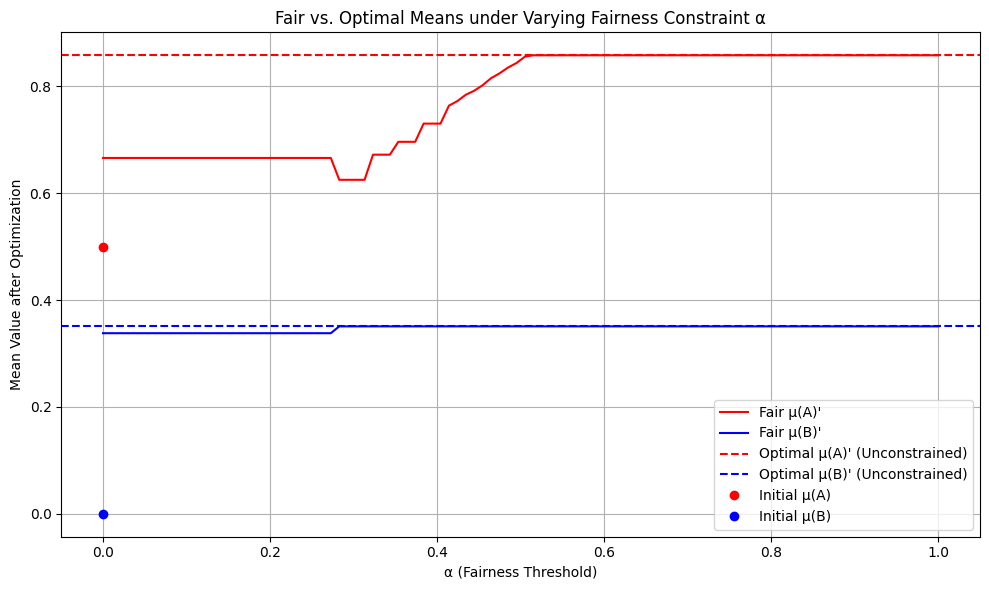

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated Gaussian samples for groups A and B
n_samples = 100
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1
x_min, x_max = 0, 1  # Alpha values to test

np.random.seed(1)
A = np.random.normal(mean_a, std_a, n_samples)
B = np.random.normal(mean_b, std_b, n_samples)

x_vals = np.linspace(x_min, x_max, num=100)

# Store results
x1 = []
fair_mean_A = []
fair_mean_B = []

# Unconstrained optimal means
opt_result_A = opt_step(A, 1, -1, 1, -1)[0]
opt_result_B = opt_step(B, 1, -1, 1, -1)[0]
y3 = np.mean(opt_result_A)
y4 = np.mean(opt_result_B)

# Run fair optimization over a range of alpha values
for alpha in x_vals:
    updated = fair_opt_step(A, B, 1, -1, 1, -1, alpha)[3]
    if updated is not None:
        updated_A, updated_B = updated
        x1.append(alpha)
        fair_mean_A.append(updated_A)
        fair_mean_B.append(updated_B)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x1, fair_mean_A, label="Fair μ(A)'", color='red')
plt.plot(x1, fair_mean_B, label="Fair μ(B)'", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)\' (Unconstrained)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)\' (Unconstrained)')
plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
plt.plot(0, mean_b, 'bo', label='Initial μ(B)')

plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
plt.xlabel("α (Fairness Threshold)")
plt.ylabel("Mean Value after Optimization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


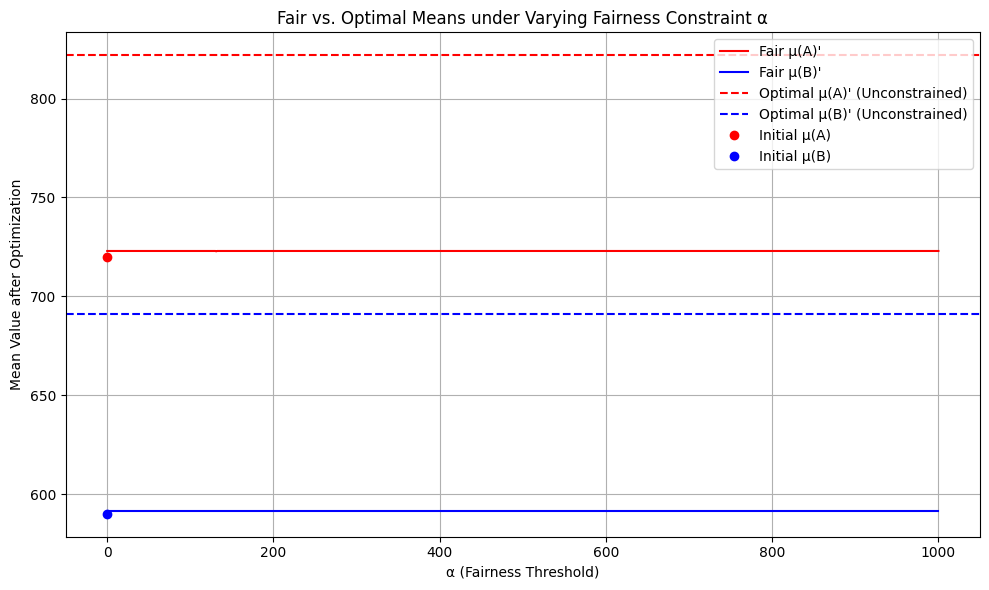

In [ ]:

# Simulated Gaussian samples for groups A and B
n_samples = 1000
mean_a, std_a = 720, 50 
mean_b, std_b = 590, 40 
x_min, x_max = 0, 1000  # Alpha values to test

np.random.seed(1)
A = np.random.normal(mean_a, std_a, n_samples)
B = np.random.normal(mean_b, std_b, n_samples)

x_vals = np.linspace(x_min, x_max, num=1000)

# Store results
x1 = []
fair_mean_A = []
fair_mean_B = []

# Unconstrained optimal means
opt_result_A = opt_step(A, 100, -100, 100, -100)[0]
opt_result_B = opt_step(B, 100, -100, 100, -100)[0]
y3 = np.mean(opt_result_A)
y4 = np.mean(opt_result_B)

# Run fair optimization over a range of alpha values
for alpha in x_vals:
    updated = fair_opt_step(A, B, 1, -1, 1, -1, alpha)[3]
    if updated is not None:
        updated_A, updated_B = updated
        x1.append(alpha)
        fair_mean_A.append(np.mean(updated_A))
        fair_mean_B.append(np.mean(updated_B))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x1, fair_mean_A, label="Fair μ(A)'", color='red')
plt.plot(x1, fair_mean_B, label="Fair μ(B)'", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)\' (Unconstrained)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)\' (Unconstrained)')
plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
plt.plot(0, mean_b, 'bo', label='Initial μ(B)')

plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
plt.xlabel("α (Fairness Threshold)")
plt.ylabel("Mean Value after Optimization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.1243453636632417), np.float64(2.600255136478842), np.float64(1.6337694423354374), np.float64(-0.37785841792137176), np.float64(0.11594564533158436), np.float64(0.11594564533158436), np.float64(0.11594564533158436), np.float64(0.11594564533158436), np.float64(0.11594564533158436)]


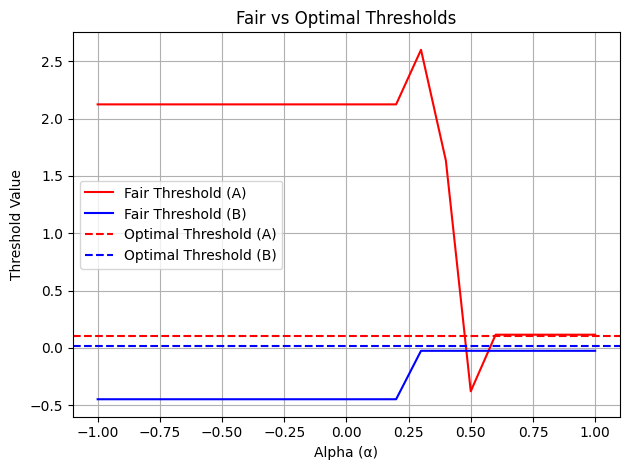

In [14]:
### Plotting the Fair Thresholds and Optimal Thresholds

n_samples = 100
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1
x_min, x_max = -1, 1

np.random.seed(1)
A = np.random.normal(mean_a, std_a, n_samples)
B = np.random.normal(mean_b, std_b, n_samples)

x = np.linspace(x_min, x_max, num=21)

x1 = []
y1 = []
y2 = []
y3 = opt_step(A, 1, -1, 1, -1)[1]
y4 = opt_step(B, 1, -1, 1, -1)[1]

for i in x:
    results = fair_opt_step(A, B, 1, -1, 1, -1, alpha=i)
    if results[0] is not None and results[1] is not None:
        x1.append(i)
        y1.append(results[0])
        y2.append(results[1])
    else:
        continue

print(y1)
plt.plot(x1, y1, label="Fair Threshold (A)", color='red')
plt.plot(x1, y2, label="Fair Threshold (B)", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal Threshold (A)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal Threshold (B)')

plt.title("Fair vs Optimal Thresholds")
plt.xlabel("Alpha (α)")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()


In [ ]:
print(min(A), max(A))
print(min(B), max(B))

-1.8015386968802827 2.2448117642164798
-1.1173103486352778 1.6598021771098705
